In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
city_data = pd.ExcelFile("附件1.xlsx",engine='openpyxl')
city_data = city_data.parse('城市疫情')

In [3]:
end_date = datetime(2020,6,30)
#根据城市分组，找到每个城市首次出现病例的开始日期。
start_date = city_data.groupby('城市')['日期'].min()
# print(start_date)
start_date = start_date.reset_index(drop=False)
# print(start_date)
city_len = start_date.shape[0]
temp = pd.DataFrame()
lis4 = []
lis3 = []
for index,row in start_date.iterrows():
    # 生成开始日期到6-30之间的所有日期
    lis1 = pd.date_range(row['日期'],end_date)
    lis2 = [row['城市']] * len(lis1)
    lis4.extend(lis2)
    lis3.extend(lis1)
temp['日期'] = lis3
temp['城市'] = lis4


In [29]:
# 计算累计确诊人数
city_data['累计确诊人数']=city_data['新增确诊'].groupby(city_data['城市']).cumsum()
city_data['累计自愈人数']=city_data['新增治愈'].groupby(city_data['城市']).cumsum()
city_data['累计死亡人数']=city_data['新增死亡'].groupby(city_data['城市']).cumsum()
col = ['城市','日期','累计确诊人数','累计自愈人数','累计死亡人数']
task1 = city_data.loc[:,col]
#将两张表左连接，生成全量日期的数据
task1 = temp.merge(task1,on=['日期','城市'],how = 'left')
#缺失值填充为距离最近日期的非缺失数据
task1.fillna(method="ffill",inplace=True)
#输出保存为csv格式
task1.to_csv('task1_1.csv')
task1.head()
target=task1.loc[task1['城市'].isin(['武汉','深圳','保定'])].copy()
# 切片找到日期以10，25结束的日期
target['temp']=target['日期'].apply(lambda x :1 if str(x)[8:10] in ['10','25'] else 0).copy()
target=target.loc[target['temp']==1].copy()
target=target.reset_index(drop=True)
#删除临时列
target=target.drop('temp',axis=1)
target.to_csv('WHSZBD.csv')
target.head()

,日期,城市,累计确诊人数,累计自愈人数,累计死亡人数
0,2020-01-25,保定,3.0,0.0,0.0
1,2020-02-10,保定,30.0,9.0,0.0
2,2020-02-25,保定,32.0,32.0,0.0
3,2020-03-10,保定,32.0,32.0,0.0
4,2020-03-25,保定,32.0,32.0,0.0


In [32]:
# 1.2 
city_data = pd.ExcelFile("附件1.xlsx",engine='openpyxl')
city_province = city_data.parse('城市省份对照表')
city_data = city_data.parse('城市疫情')
task2 = task1.merge(city_province,on="城市",how="left")
task2['日期'] = task2['日期'].apply(lambda x: pd.to_datetime(x))
result = task2.merge(city_data,on=['城市','日期'],how='left')
#左连接之后，有些日期没有新增确诊，新增治愈，新增死亡，需要填充为0
result = result.fillna(value=0)

,日期,城市,累计确诊人数,累计自愈人数,累计死亡人数,省份,新增确诊,新增治愈,新增死亡
0,2020-01-26,七台河,1.0,0.0,0.0,黑龙江,1.0,0.0,0.0
1,2020-01-27,七台河,2.0,0.0,0.0,黑龙江,1.0,0.0,0.0
2,2020-01-28,七台河,2.0,0.0,0.0,黑龙江,NaN,NaN,NaN
3,2020-01-29,七台河,2.0,0.0,0.0,黑龙江,NaN,NaN,NaN
4,2020-01-30,七台河,3.0,0.0,0.0,黑龙江,1.0,0.0,0.0


In [49]:
#根据省份分类求和
total = result.groupby(['省份','日期']).sum().copy()
# 将索引改变为正常的列名
total.reset_index(drop=False,inplace=True)
total.head()

C:\Users\吕强\AppData\Local\Temp\ipykernel_9580\400093699.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total = result.groupby(['省份','日期']).sum().copy()


,累计确诊人数,累计自愈人数,累计死亡人数,新增确诊,新增治愈,新增死亡
0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,1.0,0.0


In [41]:
# 输出文件
total.to_csv('task1_2.csv')
part = total.loc[total['省份'].isin(['湖北','广东','河北'])].copy()
#设置临时变量，找到每个月的15号
part['temp'] = part['日期'].apply(lambda x: 1 if str(x)[8:10] in ['15'] else 0).copy()
part=part.loc[part['temp'] == 1].copy()

,省份,日期,累计确诊人数,累计自愈人数,累计死亡人数,新增确诊,新增治愈,新增死亡,temp
1970,广东,2020-02-15,1316.0,434.0,2.0,22.0,50.0,0.0,1
1999,广东,2020-03-15,1361.0,1292.0,8.0,4.0,5.0,0.0,1
2030,广东,2020-04-15,1571.0,1392.0,8.0,5.0,0.0,0.0,1
2060,广东,2020-05-15,1589.0,1392.0,8.0,0.0,0.0,0.0,1
2091,广东,2020-06-15,1628.0,1394.0,8.0,3.0,0.0,0.0,1


In [52]:
# 按照指定顺序输出
col_name = ['省份','日期','新增确诊','新增治愈','新增死亡','累计确诊人数','累计自愈人数','累计死亡人数']
part = part.loc[:,col_name]
part.head()

,省份,日期,新增确诊,新增治愈,新增死亡,累计确诊人数,累计自愈人数,累计死亡人数
1970,广东,2020-02-15,22.0,50.0,0.0,1316.0,434.0,2.0
1999,广东,2020-03-15,4.0,5.0,0.0,1361.0,1292.0,8.0
2030,广东,2020-04-15,5.0,0.0,0.0,1571.0,1392.0,8.0
2060,广东,2020-05-15,0.0,0.0,0.0,1589.0,1392.0,8.0
2091,广东,2020-06-15,3.0,0.0,0.0,1628.0,1394.0,8.0


In [55]:
#1.3
task3 = pd.read_csv('task1_2.csv',encoding='utf-8')
task3['住院人数']=task3['累计确诊人数']-task3['累计自愈人数']-task3['累计死亡人数']
col=['省份','日期','住院人数']
task3 = task3.loc[:,col]
task3['temp']=task3['日期'].apply(lambda x : 1 if str(x)[8:10] in ['20'] else 0)
task3 = task3.loc[task3['temp']==1]
task3 = task3.loc[:,col]
part = task3.loc[task3['省份'].isin (['湖北','广东','上海'])]
part.head()

,省份,日期,住院人数
0,上海,2020-01-20,1.0
31,上海,2020-02-20,135.0
60,上海,2020-03-20,55.0
91,上海,2020-04-20,115.0
121,上海,2020-05-20,30.0


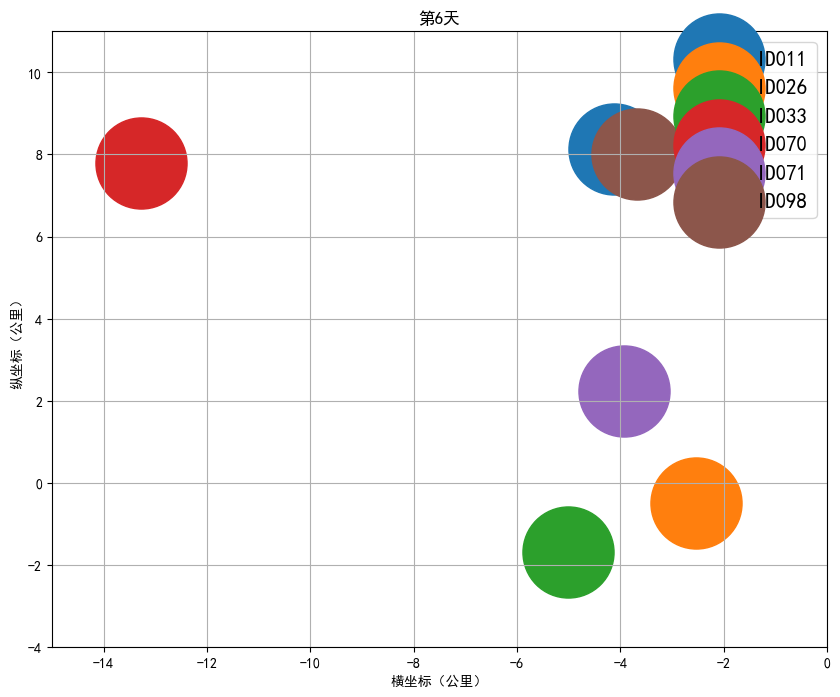

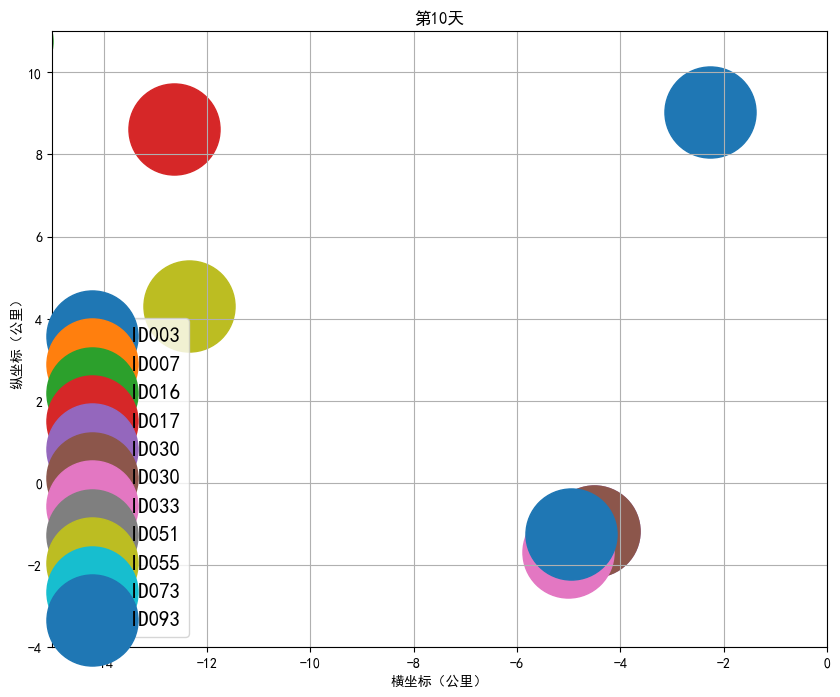

In [58]:
import matplotlib.pyplot as plt
city_data = pd.ExcelFile("附件1.xlsx",engine='openpyxl')
area = city_data.parse('A市涉疫场所分布')
list1 = [6,10]
for i in list1:
    da_sheet3 = area[area['通报日期'] == i]
    x, y = da_sheet3['横坐标（公里）'], da_sheet3['纵坐标（公里）']
    label = da_sheet3['疫情场所']
    figure = plt.figure(figsize=(10, 8))
    c1 = np.random.rand(1,len(x))
    for j in range(0,len(x)):
        k =label.iloc[j]
        plt.scatter(x.iloc[j], y.iloc[j], s=4300,label = k)  # 对于圆形，圆的面积为 area = pi/4*s .
    plt.legend(prop={'family': 'SimHei', 'size': 15})  # fontproperties='SimHei'字体设置显示中文
    plt.xlabel('横坐标（公里）')
    plt.ylabel('纵坐标（公里）')
    plt.rcParams['font.sans-serif'] = 'SimHei'  # 设置字体显示中文
    plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
    plt.xlim(-15, 0)
    plt.ylim(-4, 11)
    plt.grid(True)
    plt.title('第{}天'.format(i))
    plt.show()
